# 05 – Transfer Learning with YAMNet Embeddings

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Transfer Learning with Pre-trained Audio Embeddings (YAMNet)

---

## Overview

In this notebook, we extend our previous experiments (02–04) by using
**transfer learning** with a pre-trained audio model, **YAMNet**, to classify
animal sounds (`dog`, `cat`, `bird`).

Instead of training a CNN from scratch on Mel-spectrograms, we:

1. Use a pre-trained YAMNet model (trained on AudioSet) to extract
   high-level audio **embeddings** from each waveform.

2. Train a small neural network (Dense layers) **on top of these embeddings**
   to classify our three animal classes.

3. Compare this transfer-learning approach to our best CNN from
   `04_cnn_full_data.ipynb` (CNN + Dropout 0.3).

**Goals:**

- Reuse the same dataset and class labels as before.
- Keep a similar **train/validation/test split** (stratified, random_state=42).
- Evaluate test accuracy, confusion matrix, and per-class metrics.
- Discuss how transfer learning compares to our custom CNN models.


## 1. Setup and Configuration

We import TensorFlow, TensorFlow Hub (for YAMNet), librosa, NumPy, and sklearn; and set constants similar to notebook 04.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import librosa
import librosa.display

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Paths and constants
DATA_DIR = Path("../data").resolve()
SAMPLE_RATE = 16000  # YAMNet expects 16 kHz audio

CLASS_NAMES = ["dog", "cat", "bird"]
label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}

# Train/val/test ratios (match notebook 04)
TEST_SIZE = 0.15
VAL_SIZE = 0.15  # of the remaining after test split


## 2. Dataset: File Paths and Labels

We reuse the same `data/` directory structure:

- `data/dog/*.wav`
- `data/cat/*.wav`
- `data/bird/*.wav`

Here we collect:

- `file_paths`: list of `Path` objects to WAV files
- `labels`: integer label indices (`0 = dog`, `1 = cat`, `2 = bird`)


In [11]:
def collect_file_paths_and_labels(data_dir: Path):
    """Collect all .wav file paths and integer labels."""
    file_paths = []
    labels = []
    
    for label in CLASS_NAMES:
        class_dir = data_dir / label
        wav_files = sorted(class_dir.glob("*.wav"))
        
        for audio_path in wav_files:
            file_paths.append(audio_path)
            labels.append(label_to_index[label])
    
    return np.array(file_paths), np.array(labels, dtype=np.int32)

file_paths, labels = collect_file_paths_and_labels(DATA_DIR)
print("Total files:", len(file_paths))
for idx, label_name in enumerate(CLASS_NAMES):
    count = np.sum(labels == idx)
    print(f"{label_name}: {count} files")


Total files: 610
dog: 210 files
cat: 207 files
bird: 193 files


## 3. Stratified Train / Validation / Test Split

We create explicit train, validation, and test sets using stratified splits.
We use the **same ratios and random_state=42** as in `04_cnn_full_data.ipynb` so
the splits are comparable:

- Test set: 15% of data
- From the remaining 85%, we take 15% as validation


In [12]:
# First split off test set
paths_train_full, paths_test, y_train_full, y_test = train_test_split(
    file_paths,
    labels,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=labels,
)

# Now split train_full into train and validation
paths_train, paths_val, y_train, y_val = train_test_split(
    paths_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full,
)

print("Train size:", len(paths_train))
print("Validation size:", len(paths_val))
print("Test size:", len(paths_test))

def print_split_stats(name, y_split):
    print(f"\n{name} distribution:")
    for idx, label_name in enumerate(CLASS_NAMES):
        count = np.sum(y_split == idx)
        print(f"  {label_name}: {count}")

print_split_stats("Train", y_train)
print_split_stats("Validation", y_val)
print_split_stats("Test", y_test)


Train size: 440
Validation size: 78
Test size: 92

Train distribution:
  dog: 151
  cat: 150
  bird: 139

Validation distribution:
  dog: 27
  cat: 26
  bird: 25

Test distribution:
  dog: 32
  cat: 31
  bird: 29


## 4. YAMNet: Pre-trained Audio Model

We use **YAMNet**, a convolutional neural network trained on Google's
AudioSet dataset. It takes a 16 kHz mono waveform and outputs:

- Class scores (for many audio event classes),
- Intermediate **embeddings** (1024-dimensional vectors),
- Log Mel-spectrogram (internal representation).

For transfer learning, we will:

1. Load each audio file at 16 kHz (mono).
2. Pass the waveform through YAMNet.
3. Take the **average** of all frame-level embeddings to get a single
   1024-D embedding vector per clip.
4. Use these embeddings as input features to a small classifier network.

**Note on YAMNet loading:**

On some macOS Python installations, HTTPS certificate issues can prevent
`tensorflow_hub` from downloading models from `tfhub.dev`. To make our project
reproducible and avoid SSL problems, we manually downloaded the YAMNet SavedModel
and load it from a local path (`../models/yamnet/`) instead of from the remote URL.


In [13]:
# Load YAMNet from local path (downloaded SavedModel)
# This avoids SSL certificate issues and makes the project reproducible
YAMNET_HANDLE = Path("../models/yamnet").resolve().as_posix()

print("Using local YAMNet model at:", YAMNET_HANDLE)
yamnet_model = hub.load(YAMNET_HANDLE)
print("YAMNet loaded successfully.")


Using local YAMNet model at: /Users/abhiyansainju/Desktop/GW Classes/Fall 2025/Neural Networks and Deep Learning CSCI_6366_80/Audio Classification/audio-classification-cnn/models/yamnet
YAMNet loaded successfully.


## 5. Helper Functions: Waveforms → YAMNet Embeddings

We now define:

- `load_waveform(path)`: load a mono waveform at 16 kHz using `librosa`.
- `yamnet_embedding_for_file(path)`: run YAMNet and average frame-level
  embeddings to get a single 1024-D vector.
- `compute_embeddings(file_paths)`: apply this to a list of paths and
  return an array of shape `(N, embedding_dim)`.


In [14]:
def load_waveform(path: Path, sample_rate: int = SAMPLE_RATE) -> np.ndarray:
    """Load a mono waveform at the desired sample rate."""
    y, sr = librosa.load(path, sr=sample_rate, mono=True)
    return y.astype(np.float32)

def yamnet_embedding_for_file(path: Path) -> np.ndarray:
    """Compute YAMNet embedding (1024-D) for a single audio file."""
    # 1. Load audio at 16 kHz (mono)
    waveform, sr = librosa.load(path, sr=16000, mono=True)
    waveform = waveform.astype(np.float32)
    
    # 2. Convert to Tensor *without* adding a batch dimension
    waveform_tf = tf.convert_to_tensor(waveform, dtype=tf.float32)
    # IMPORTANT: do NOT reshape to (1, -1). YAMNet expects shape (num_samples,)
    
    # 3. Run YAMNet
    # YAMNet returns: scores, embeddings, spectrogram
    scores, embeddings, spectrogram = yamnet_model(waveform_tf)
    
    # 4. Average embeddings over time frames to get a single 1024-D vector
    embedding_mean = tf.reduce_mean(embeddings, axis=0)  # shape: (1024,)
    
    # 5. Return as NumPy array
    return embedding_mean.numpy()

def compute_embeddings(file_paths: np.ndarray) -> np.ndarray:
    """Compute YAMNet embeddings for a list/array of file paths."""
    all_embeddings = []
    for i, path in enumerate(file_paths):
        if i % 50 == 0:
            print(f"Processing file {i}/{len(file_paths)}: {path.name}")
        emb = yamnet_embedding_for_file(path)
        all_embeddings.append(emb)
    return np.stack(all_embeddings, axis=0)


## 6. Build Embeddings for Train / Validation / Test

We now compute YAMNet embeddings for:

- `paths_train` → `X_train_embed`
- `paths_val` → `X_val_embed`
- `paths_test` → `X_test_embed`

Then we convert integer labels (`0,1,2`) into one-hot vectors of length 3.


In [15]:
# Compute embeddings (this may take some time on CPU)
X_train_embed = compute_embeddings(paths_train)
X_val_embed = compute_embeddings(paths_val)
X_test_embed = compute_embeddings(paths_test)

print("Embedding shapes:")
print("  Train:", X_train_embed.shape)
print("  Val:  ", X_val_embed.shape)
print("  Test: ", X_test_embed.shape)

# One-hot encode labels
num_classes = len(CLASS_NAMES)

def to_one_hot(y_int: np.ndarray, num_classes: int) -> np.ndarray:
    y_one_hot = np.zeros((len(y_int), num_classes), dtype=np.float32)
    for i, idx in enumerate(y_int):
        y_one_hot[i, idx] = 1.0
    return y_one_hot

y_train_oh = to_one_hot(y_train, num_classes)
y_val_oh = to_one_hot(y_val, num_classes)
y_test_oh = to_one_hot(y_test, num_classes)

print("Label shapes (one-hot):")
print("  Train:", y_train_oh.shape)
print("  Val:  ", y_val_oh.shape)
print("  Test: ", y_test_oh.shape)


Processing file 0/440: 5236848b_nohash_0.wav
Processing file 50/440: 89865a6f_nohash_1.wav
Processing file 100/440: 283d7a53_nohash_0.wav
Processing file 150/440: cf68fad2_nohash_0.wav
Processing file 200/440: 402e2977_nohash_1.wav
Processing file 250/440: b843de62_nohash_1.wav
Processing file 300/440: 98447c43_nohash_0.wav
Processing file 350/440: 1942abd7_nohash_0.wav
Processing file 400/440: 4ca37738_nohash_0.wav
Processing file 0/78: 4c13fe25_nohash_1.wav
Processing file 50/78: db9d52d2_nohash_0.wav
Processing file 0/92: 9e2ce5e3_nohash_0.wav
Processing file 50/92: 48a9f771_nohash_1.wav
Embedding shapes:
  Train: (440, 1024)
  Val:   (78, 1024)
  Test:  (92, 1024)
Label shapes (one-hot):
  Train: (440, 3)
  Val:   (78, 3)
  Test:  (92, 3)


## 7. Plotting Helper for Training Curves

We reuse the same helper function to plot training and validation loss
and accuracy over epochs.


In [16]:
def plot_training_curves(history, title_prefix=""):
    """Plot training and validation loss/accuracy."""
    history_dict = history.history

    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Training vs Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


## 8. Define the Transfer-Learning Classifier

We now define a simple classifier that takes YAMNet embeddings as input:

- Input: 1024-D embedding vector
- Dense(128, ReLU) + Dropout(0.3)
- Dense(3, Softmax)

We use the same loss and optimizer as before (`categorical_crossentropy` +
`adam`).


In [17]:
def build_yamnet_classifier(input_dim: int, num_classes: int = 3, dropout_rate: float = 0.3):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

input_dim = X_train_embed.shape[1]
yamnet_model_head = build_yamnet_classifier(input_dim=input_dim, num_classes=num_classes)
yamnet_model_head.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,587 (514.01 KB)

 Trainable params: 131,587 (514.01 KB)

 Non-trainable params: 0 (0.00 B)

## 9. Training the YAMNet Embedding Classifier

We train the classifier on top of YAMNet embeddings using the same
train/validation split as before.

- Epochs: 20
- Batch size: 16




Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3591 - loss: 1.1988 - val_accuracy: 0.4231 - val_loss: 1.0536
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5091 - loss: 1.0135 - val_accuracy: 0.4872 - val_loss: 1.0094
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5705 - loss: 0.9429 - val_accuracy: 0.5513 - val_loss: 0.9750
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6091 - loss: 0.8785 - val_accuracy: 0.5769 - val_loss: 0.9496
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6432 - loss: 0.8598 - val_accuracy: 0.5769 - val_loss: 0.9281
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7000 - loss: 0.7704 - val_accuracy: 0.5769 - val_loss: 0.9043
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7000 - loss: 0.7416 - val_accuracy: 0.5256 - val_loss: 0.9210
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7409 - loss: 0.6912 - val_accuracy: 0.5513 - val_loss:

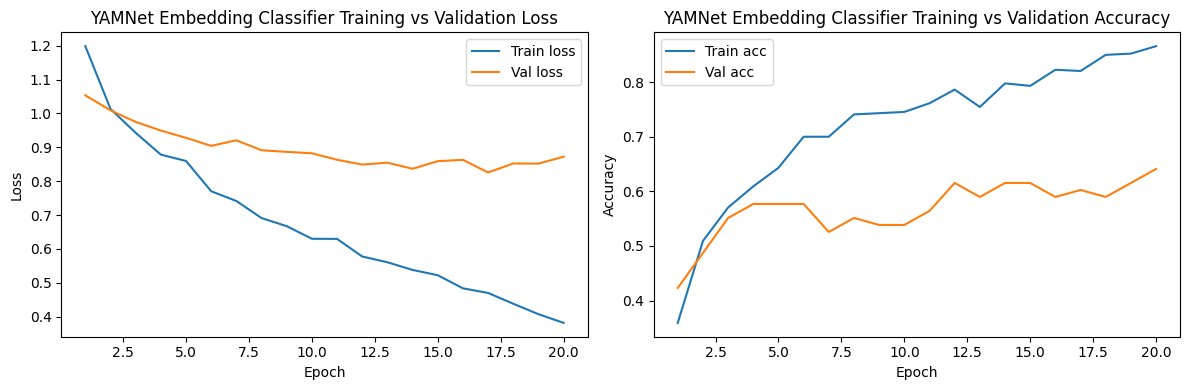

In [18]:
EPOCHS = 20
BATCH_SIZE = 16

yamnet_history = yamnet_model_head.fit(
    X_train_embed,
    y_train_oh,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_embed, y_val_oh),
    verbose=1,
)

plot_training_curves(yamnet_history, title_prefix="YAMNet Embedding Classifier")


## 10. Evaluation on the Held-out Test Set

We now evaluate the YAMNet-based classifier on the test set (92 clips),
and compute:

- Test loss and accuracy
- Confusion matrix
- Per-class precision, recall, and F1-score


In [19]:
def evaluate_model_embeddings(model, X_test, y_test_oh, y_test_int, model_name="Model"):
    """Evaluate a classifier on embedding features and print metrics."""
    test_loss, test_acc = model.evaluate(X_test, y_test_oh, verbose=0)
    print(f"{model_name} - Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nConfusion matrix:")
    cm = confusion_matrix(y_test_int, y_pred)
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_test_int, y_pred, target_names=CLASS_NAMES))

    return test_loss, test_acc, cm

print("=" * 60)
print("YAMNet Embedding Classifier RESULTS")
print("=" * 60)
yamnet_results = evaluate_model_embeddings(
    yamnet_model_head,
    X_test_embed,
    y_test_oh,
    y_test,
    model_name="YAMNet + Dense Head",
)


YAMNet Embedding Classifier RESULTS
YAMNet + Dense Head - Test loss: 0.8990, Test accuracy: 0.6196

Confusion matrix:
[[14  4 14]
 [ 0 24  7]
 [ 2  8 19]]

Classification report:
              precision    recall  f1-score   support

         dog       0.88      0.44      0.58        32
         cat       0.67      0.77      0.72        31
        bird       0.47      0.66      0.55        29

    accuracy                           0.62        92
   macro avg       0.67      0.62      0.62        92
weighted avg       0.68      0.62      0.62        92



## 11. Summary and Comparison with CNN Models

### YAMNet Transfer Learning Results

From the evaluation above, the YAMNet-based classifier achieved:

- **Test accuracy**: ≈62% (0.6196)
- **Test loss**: 0.8990
- **Macro-averaged F1-score**: ≈0.62

**Per-class performance:**
- **Dog**: Precision 0.88, Recall 0.44, F1-score 0.58
- **Cat**: Precision 0.67, Recall 0.77, F1-score 0.72
- **Bird**: Precision 0.47, Recall 0.66, F1-score 0.55

### Comparison with CNN Models (from `04_cnn_full_data.ipynb`)

| Model | Test Accuracy | Test Loss | Macro F1 | Notes |
|-------|--------------:|----------:|---------:|-------|
| **Baseline CNN** | 83.70% | 0.6283 | ~0.81 | Trained from scratch on Mel-spectrograms |
| **CNN + Dropout(0.3)** | **88.04%** | 0.5503 | ~0.88 | Best CNN model |
| **YAMNet + Dense Head** | 61.96% | 0.8990 | ~0.62 | Transfer learning with pre-trained embeddings |

### Key Observations

1. **CNN models outperform YAMNet transfer learning** on this specific task:
   - The best CNN (with Dropout) achieves 88% test accuracy vs 62% for YAMNet
   - This suggests that training from scratch on Mel-spectrograms is more effective for this particular animal sound classification task

2. **YAMNet's strengths and limitations**:
   - YAMNet was trained on AudioSet (general audio events), not specifically on animal sounds
   - The embeddings may not capture the most discriminative features for dog/cat/bird classification
   - However, YAMNet requires less training time (only training a small Dense head vs full CNN)

3. **Per-class analysis**:
   - YAMNet performs best on **cat** (F1: 0.72), similar to CNN models
   - YAMNet struggles more with **dog** (F1: 0.58) and **bird** (F1: 0.55)
   - The CNN models show more balanced performance across all classes

4. **Why CNN might be better here**:
   - Our dataset is relatively small (610 clips), so transfer learning may not provide as much benefit
   - The CNN can learn task-specific features directly from Mel-spectrograms
   - YAMNet's general-purpose embeddings may not align well with our specific classification task

### Conclusion

For this animal sound classification task, **training a CNN from scratch on Mel-spectrograms** (with Dropout regularization) outperforms transfer learning with YAMNet embeddings. This demonstrates that:

- Transfer learning is not always better - it depends on the task and dataset
- For domain-specific tasks with sufficient data, training from scratch can be more effective
- The choice between transfer learning and training from scratch should be based on empirical results, not assumptions

However, YAMNet transfer learning could still be valuable if:
- We had even less training data
- We wanted faster training (only training the classifier head)
- We were doing multi-task learning across many audio event types
